# CNN for Dogs vs Cats.

For this project I've used the following tutorial on kaggle: <br>
https://www.kaggle.com/code/ivanshingel/cnn-for-beginners-complete-guide

## 1. Loading libraries

In [2]:
import os
import imp
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models

# ml lib
from sklearn.model_selection import train_test_split

C:\Users\Warmtebron\AppData\Local\Temp\ipykernel_20816\302145005.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
# Global vars

# Seed is a global variable that is used to seed the random number generators. 
# This ensures that the results are reproducible across multiple runs.
SEED = 127
TRAIN_PATH = 'dogs-vs-cats/train/train'
TEST_PATH = 'dogs-vs-cats/test1/test1'
# TRAIN_BATCHSIZE and TEST_BATCHSIZE are global variables 
# that specify the batch sizes to be used during training and testing, respectively.
TRAIN_BATCHSIZE = 32
TEST_BATCHSIZE = 128

# EPOCHS_sfmmd, EPOCHS_densn121, and EPOCHS_resnet18 are global 
# variables that specify the number of epochs to train the models for.
EPOCHS_sfmmd = 7
EPOCHS_densn121 = 7
EPOCHS_resnet18 = 7

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

READY_MODELS_PATH = 'saved_models/'

## 2. EDA

In [4]:
# manual_seed
torch.manual_seed(SEED)

### 2.1 Data first look

In [5]:
os.listdir('dogs-vs-cats')

['sampleSubmission.csv', 'test1', 'train']

In [6]:
# get labels

labels_list = []
train_imgs = os.listdir('dogs-vs-cats/train/train')

for f in train_imgs:
    
    # 0 for 'cat', 1 for 'dog'
    if f.split('.')[0] == 'cat':
        labels_list.append(0)

    elif f.split('.')[0] == 'dog':
        labels_list.append(1)

    else:
    # if no label 
        labels_list.append(-1)

print(f'Images count = {len(train_imgs)}\nLabels count = {len(labels_list)}')

Images count = 25000
Labels count = 25000


In [7]:
df_train = pd.DataFrame(columns= ['image', 'label'])
df_train['image'] = train_imgs
df_train['label'] = labels_list

df_train.tail(3)

,image,label
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


In [8]:
df_train['label'].unique()

array([0, 1], dtype=int64)

Text(0.5, 1.0, 'Count of labels')

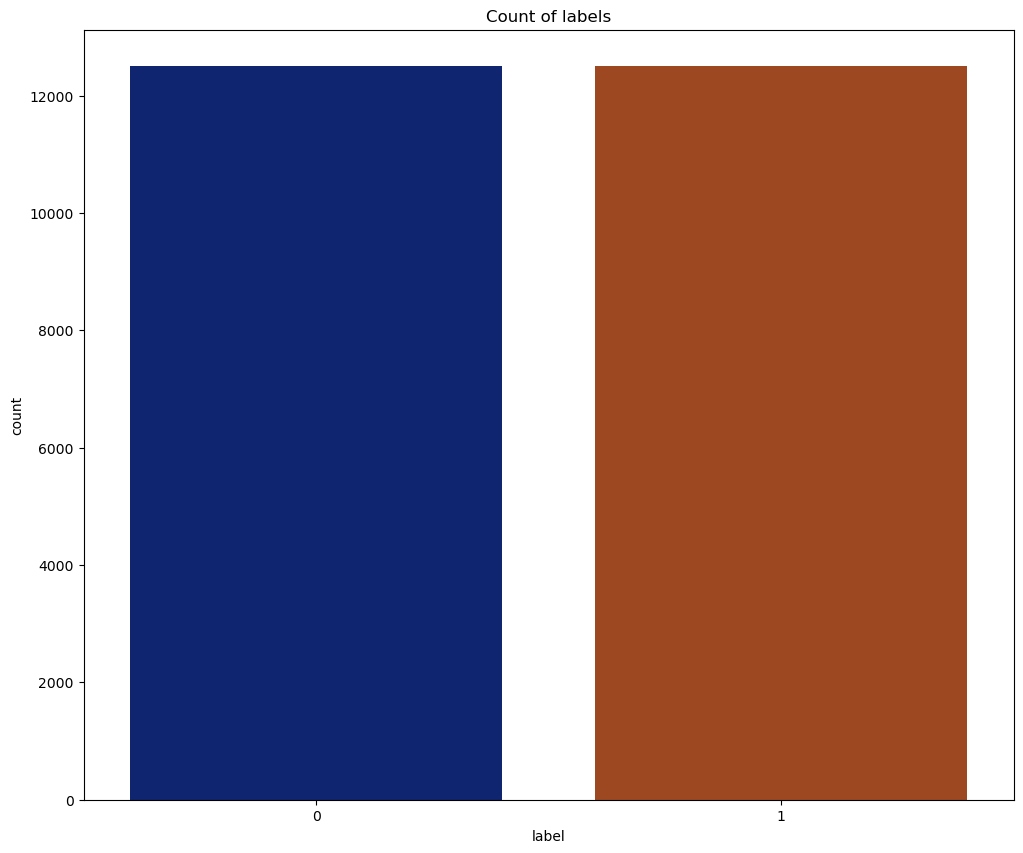

In [9]:
plt.rcParams['figure.figsize'] = (12,10)
ax = sns.countplot(data= df_train, x= 'label', palette= 'dark')
ax.set_title('Count of labels')

This code determines the number of unique shapes (width and height) of images in the training dataset. This information can be useful for determining the appropriate input size for a CNN model, as the input size needs to be fixed across all images.

In [10]:
shape_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])

    with Image.open(img_path) as img:
        width, height = img.size
        shape_arr.append((width, height))

np.unique(shape_arr, axis= 0).__len__()

8513

8513 unique shapes of images, so reshape is needed.

In [11]:
# returns a tuple of two values: 
# the maximum width and the maximum height among all the images in the training dataset.
np.max(shape_arr, axis= 0)

array([1050,  768])

In [12]:
# returns a tuple of two values: 
# the minimum width and the maximum height among all the images in the training dataset.
np.min(shape_arr, axis= 0)

array([42, 32])

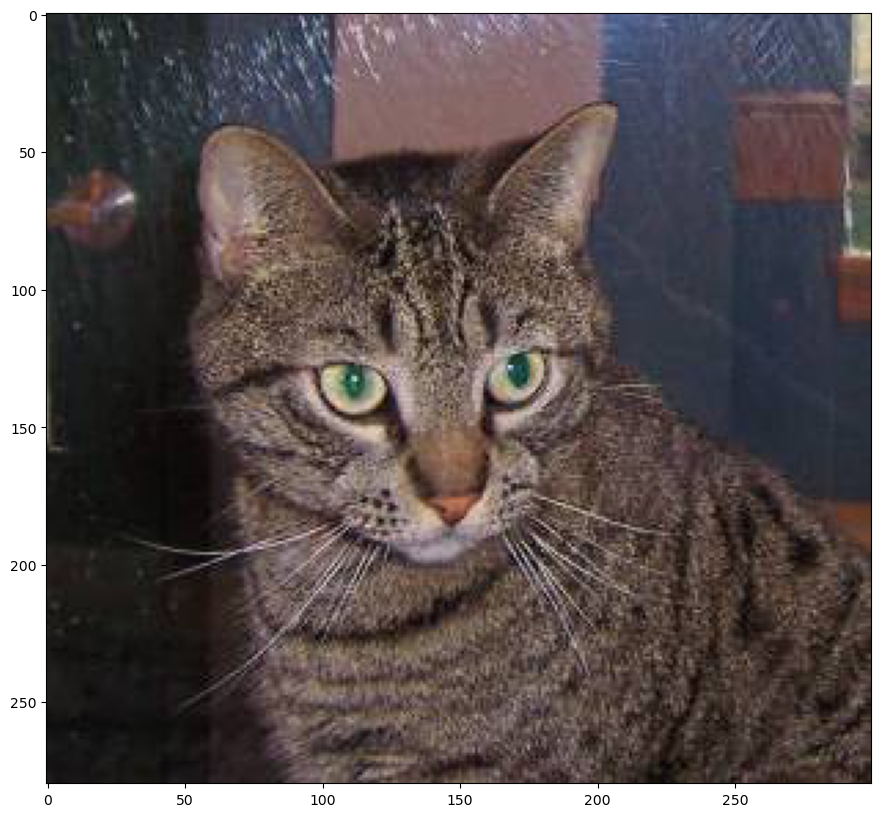

In [13]:
img_path = os.path.join(TRAIN_PATH, df_train['image'][1])

with Image.open(img_path) as img:
    plt.imshow(img)

### 2.2 Mean and std to reshape and normalize

Mean (channels)

In [14]:
r_mean_arr = []
g_mean_arr = []
b_mean_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_mean, g_mean, b_mean = np.mean(img_np, axis= (0,1))

        r_mean_arr.append(r_mean)
        g_mean_arr.append(g_mean)
        b_mean_arr.append(b_mean)

In [15]:
R_MEAN = np.mean(r_mean_arr) / 255
G_MEAN = np.mean(g_mean_arr) / 255
B_MEAN = np.mean(b_mean_arr) / 255

In [16]:
print(f"Red ch mean   = {R_MEAN}\nGreen ch mean = {G_MEAN}\nBlue ch mean  = {B_MEAN}")

Red ch mean   = 0.4883204374097956
Green ch mean = 0.45507637792683847
Blue ch mean  = 0.4169608295891638


In [17]:
r_std_arr = []
g_std_arr = []
b_std_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_std, g_std, b_std = np.std(img_np, axis= (0,1))

        r_std_arr.append(r_std)
        g_std_arr.append(g_std)
        b_std_arr.append(b_std)

In [18]:
R_STD = np.mean(r_std_arr) / 255
G_STD = np.mean(g_std_arr) / 255
B_STD = np.mean(b_std_arr) / 255

In [19]:
print(f"Red ch std   = {R_STD}\nGreen ch std = {G_STD}\nBlue ch std  = {B_STD}")

Red ch std   = 0.22954217038433447
Green ch std = 0.22502466727814602
Blue ch std  = 0.2253174306667753
